In [1]:
import cv2
import numpy as np
import os
import csv
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import joblib

In [2]:
FOLDER = './images'
CSV = 'data annotations - Feuille 1.csv'

np.random.seed(42)
random.seed(42)
cv2.setRNGSeed(42)

In [3]:
def split(train=0.8, test=0.2, shuffle=True): # le ratio pour le test sert un peu a rien...
    images_names = []

    with open(CSV, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)

        # on ignore les 2 premieres ligens
        next(reader)
        next(reader)
        
        for row in reader:
            if len(row) < 2 or not row[0]:  # ignorer les lignes vides ou incompletes
                continue
            
            image_name = row[0]
            images_names.append(image_name)

    split_id = int(len(images_names) * train)
    train_set = images_names[:split_id]
    test_set = images_names[split_id:]

    if shuffle:
        random.shuffle(train_set)
    
    return train_set, test_set

In [4]:
def extract_features(image): # extraction de features pour le modele
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape[:2]
    max_size = 512
    if max(h, w) > max_size:
        scale = max_size / max(h, w)
        gray = cv2.resize(gray, (int(w * scale), int(h * scale)))
        h, w = gray.shape[:2]
    
    # 1 Contours et lignes Hough
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30, minLineLength=40, maxLineGap=5)
    num_lines = 0
    mean_spacing = 0
    std_spacing = 0
    if lines is not None:
        horiz_y = []
        for x1, y1, x2, y2 in lines[:,0]:
            if abs(y2 - y1) < 0.2 * abs(x2 - x1):
                horiz_y.append((y1 + y2) / 2.0)
        horiz_y.sort()
        filtered_y = []
        min_sep = 0.03 * h  # 3% de la hauteur image
        for y in horiz_y:
            if not filtered_y or y - filtered_y[-1] > min_sep:
                filtered_y.append(y)
        num_lines = len(filtered_y)
        if num_lines >= 2:
            diffs = np.diff(filtered_y)
            mean_spacing = np.mean(diffs) / h
            std_spacing = np.std(diffs) / h

    # 2 Densite de contours
    edge_density = float(np.sum(edges > 0)) / (h * w)

    # 3 Profil vertical et pics
    profile = np.sum(edges, axis=1)  # somme des pixels de contours par ligne
    profile = cv2.blur(profile.reshape(-1,1), (5,1)).flatten()  # lissage
    deriv = np.diff(profile)
    peak_pos = 0
    peak_neg = 0
    for i in range(1, len(deriv)-1):
        if deriv[i] > deriv[i-1] and deriv[i] > deriv[i+1]:
            peak_pos += 1
        if deriv[i] < deriv[i-1] and deriv[i] < deriv[i+1]:
            peak_neg += 1
    peak_count = min(peak_pos, peak_neg)

    # 4 Ratio de gradients horizontaux
    hog = cv2.HOGDescriptor()
    hog_desc = hog.compute(gray)
    horiz_sum = 0
    total_sum = np.sum(hog_desc)
    for i in range(0, len(hog_desc), 9):
        horiz_sum += hog_desc[i] + hog_desc[i+8]
    horizontal_ratio = float(horiz_sum) / (total_sum + 1e-6)

    return np.array([num_lines, mean_spacing, std_spacing, peak_count, edge_density, horizontal_ratio])

In [5]:
class Dataset:
    def __init__(self):
        self.csv_file = self._load_csv()
    
    def _load_csv(self):
        csv_file = {}
        with open(CSV, 'r') as f:
            reader = csv.reader(f)
            next(reader)
            next(reader)
            for row in reader:
                if len(row) >= 2 and row[0]:
                    csv_file[row[0]] = int(row[1])
        return csv_file
    
    def _augment(self, image, label): # pour 1 image on en creer 10
        augs = []
        h, w = image.shape[:2]
        for _ in range(10):
            angle = np.random.uniform(-5, 5)
            contrast = np.random.uniform(0.8, 1.2)
            brightness = np.random.uniform(-30, 30)
            M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
            rotated = cv2.warpAffine(image, M, (w,h))
            transformed = rotated.astype(np.float32)
            transformed = contrast * transformed + brightness
            transformed = np.clip(transformed, 0, 255).astype(np.uint8)
            augs.append((transformed, label))
        
        return augs
    
    def load(self, set, augment=False):
        features, labels = [], []
        
        for name in set:
            if name in self.csv_file:
                image = cv2.imread(os.path.join(FOLDER, name))
                if image is not None:
                    if augment:
                        for aug_img, label in self._augment(image, self.csv_file[name]):
                            features.append(extract_features(aug_img))
                            labels.append(label)
                    else:
                        features.append(extract_features(image))
                        labels.append(self.csv_file[name])
    
        return np.array(features), np.array(labels)

In [6]:
class Model: # random forest avec random search
    def __init__(self):
        self.pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('model', RandomForestRegressor(
                n_jobs=4,
                random_state=42
            ))
        ])
        self.param_dist = {
            'model__n_estimators': randint(50, 1000),
            'model__max_depth': [None] + list(np.arange(5, 30, 3)),
            'model__min_samples_split': randint(2, 20),
            'model__min_samples_leaf': randint(1, 10),
            'model__max_features': ['sqrt', 'log2', 0.5, 0.8],
            'model__bootstrap': [True, False]
        }
        self.search = None
        self.best_params_ = None
        
    
    def train(self, X, y, n_iter=200):
        self.search = RandomizedSearchCV(
            self.pipeline,
            self.param_dist,
            n_iter=n_iter,
            cv=10,
            scoring='neg_mean_absolute_error',
            verbose=2,
            n_jobs=4,
            random_state=42
        )
        self.search.fit(X, y)
        self.best_params_ = self.search.best_params_
        print(f"Meilleurs parametres: {self.search.best_params_}")
        
    def evaluate(self, X, y):
        if self.search is None:
            raise ValueError("il faut d'abord entrainer le modele")
        pred = self.search.predict(X)
        mae = mean_absolute_error(y, pred)
        accuracy = np.mean(np.isclose(y, pred, rtol=0.05))  # tolerance de + ou - 5% de l'exactitude
        plt.figure(figsize=(12, 6))
        plt.title(f"MAE: {mae:.2f} | Exactitude (+-5%): {accuracy:.1%}", pad=20)
        plt.scatter(y, pred, marker='x', alpha=0.6)
        plt.plot([0, y.max()], [0, y.max()], 'k--', label='Prediction parfaite')
        plt.xlabel('Vraies valeurs')
        plt.ylabel('Predictions')
        plt.show()

    def save(self, filename="random_forest_model.joblib"):
        if self.search is None:
            raise ValueError("rien a sauvegarder, il faut d'abord entrainer le modele")
        save_data = {
            'model': self.search.best_estimator_,
            'params': self.best_params_
        }
        joblib.dump(save_data, filename)
        print(f"Sauvegarde du modele dans : {filename}")

    @classmethod # pour l'appeler depuis la classe et non d'un objet
    def load(model, filename="random_forest_model.joblib"):
        loaded_data = joblib.load(filename)
        model_instance = model()
        model_instance.search = loaded_data['model']
        model_instance.best_params_ = loaded_data['params']
        return model_instance

In [7]:
dataset = Dataset()
train, test = split()
X_train, y_train = dataset.load(train, augment=True)
X_test, y_test = dataset.load(test)

In [8]:
if os.path.exists('random_forest_model.joblib'):
    print("Chargement du modele existant")
    model = Model.load()
else:
    model = Model()
    model.train(X_train, y_train)
    model.save()

Chargement du modele existant


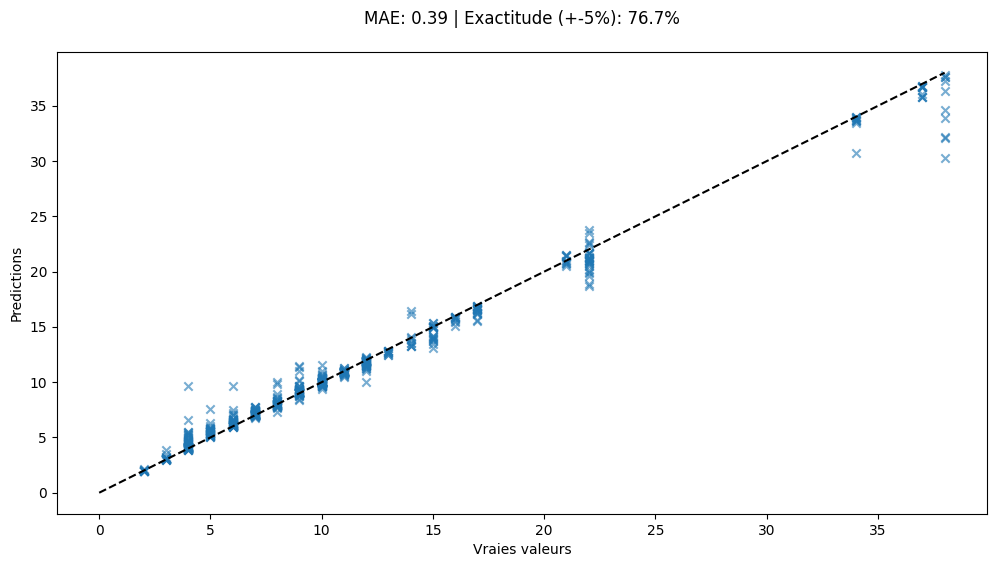

In [9]:
model.evaluate(X_train, y_train)

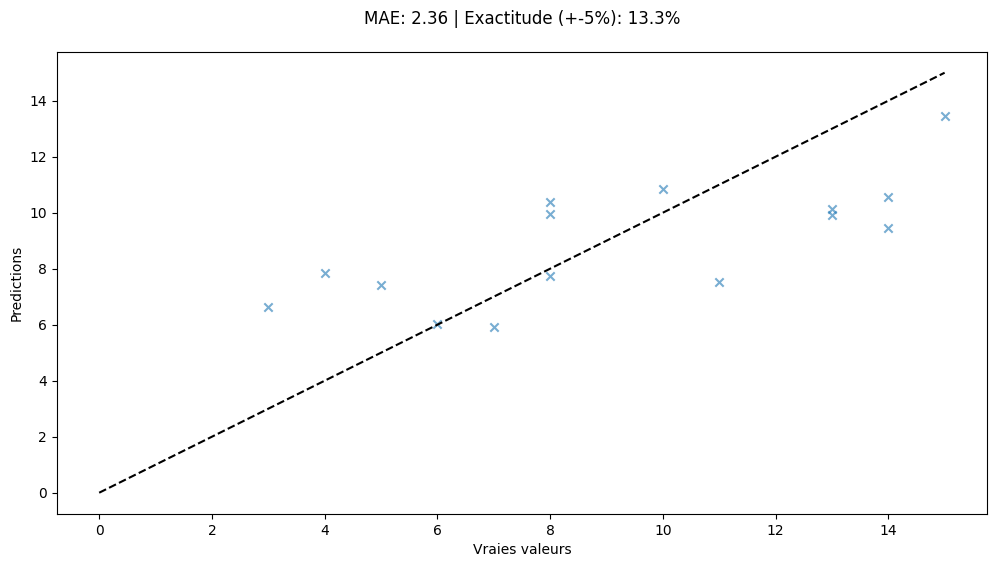

In [10]:
model.evaluate(X_test, y_test)